# Natural Language Processing for the Fake News Challenge

## Main Imports

In [46]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion, make_pipeline, make_union
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

## Set up the data for preprocessing
### Load and sample the data

In [24]:
data_folder_name = 'data'
train_body_filename = 'train_bodies.csv'
train_stance_filename = 'train_stances.csv'

train_body_path = data_folder_name +'/'+ train_body_filename 
train_stance_path = data_folder_name + '/' + train_stance_filename

body_data = pd.read_csv(train_body_path)
stance_data = pd.read_csv(train_stance_path)

In [25]:
body_data.sample(10)

,Body ID,articleBody
330,512,"Fans of ""Star Wars"" may not have to wait until..."
734,1101,"In a set of artist renditions, 9to5Mac offers ..."
943,1412,A cloistered nun has stunned her mother superi...
657,993,Sugarhill Gang founder Henry 'Big Bank Hank' J...
44,65,"McDonald’s Removing Big Mac, Apple Pies And El..."
317,497,A schoolboy who was almost killed when he was ...
1495,2249,The Department of Homeland Security is denying...
1166,1761,The Nigerian military says it has reached a ce...
1592,2398,"His voice served as a call to action, an echo ..."
1477,2221,MIAMI — The bulletin now falls squarely in the...


### Merge the data based on the Body ID to get one dataframe containing the corresponding Headlines and Article Bodies

In [48]:
total_data = pd.merge(body_data, stance_data, on='Body ID')

remove_n = 40000
drop_indices = np.random.choice(total_data.index, remove_n, replace=False)
total_data = total_data.drop(drop_indices)

total_data.sample(10)

,Body ID,articleBody,Headline,Stance
36744,1950,Mounted with a cannon and leaving a trail of s...,Texas City plumber's truck ends up in Syrian war,agree
1307,60,The White House is attempting to verify footag...,Taylor Lianne Chandler: Everything you need to...,unrelated
25039,1423,WASHINGTON -- The Pentagon says U.S. officials...,ISIL Beheads American Photojournalist in Iraq,unrelated
23563,1357,There's an illustration being shared on Facebo...,Audio recording allegedly captures at least 10...,unrelated
6795,403,WORLDWIDE - NASA has confirmed that the Earth ...,#HairGate: iPhone 6 Customers Are Complaining ...,unrelated
24307,1383,The former PricewaterhouseCoopers employee who...,Unhappy Customer: Comcast Told My Employer Abo...,discuss
30319,1689,Islamic State fighters are no match for Ebola....,Bunbury local discovered a spider had burrowed...,unrelated
16901,1006,Google Inc. (GOOGL:US) bought six office build...,Google Said to Buy Redwood City Offices for $5...,discuss
35421,1906,LONDON -- A pickup truck once owned by a plumb...,Kidnapped Nigerian schoolgirls: Government cla...,unrelated
25232,1434,Hell hath no fury like a woman scorned. The sa...,GRAPHIC CONTENT: Girl sneers at man's tiny pen...,discuss


### Splitting the dataset into train and validation sets

In [49]:
input_columns = total_data[['Headline', 'articleBody']]
target = 'Stance'
X_train, X_val, y_train, y_val = train_test_split(input_columns, total_data[target].values , test_size=0.20, random_state=0)

# check the size of our datasets
print('Size of training set:', X_train.shape)
print('Size of validation set:', X_val.shape)

X_train.sample(10)

Size of training set: (7977, 2)
Size of validation set: (1995, 2)


,Headline,articleBody
24210,ISIS Border Crisis: DHS Chief Says Terrorists ...,The Department of Homeland Security definitive...
28281,Journalist James Wright Foley reportedly behea...,"In a video posted online Tuesday, ISIS beheads..."
41455,'See you Monday': N.L. man keeps Facebook prom...,"He may have been a few hours late, but a Newfo..."
10392,Al Qaida hostage killed in raid,A man in his mid-to-late 50s is reportedly sla...
47396,Cheese blamed for North Korean leader Kim Jong...,So it wasn’t just “discomfort” that’s been tro...
25289,Was Alleged Audio of Michael Brown Shooting on...,Apple may be planning to hold a special event ...
38018,Has Ebola infected Isis militants in Mosul?,With the threat of an ISIS terror attack becom...
33158,Tourist dubbed ‘Spider Man’ after spider burro...,One passenger at Dulles International Airport ...
9999,Attorney: New audio reveals pause in gunfire w...,"""Eh-oh!"" A 19-year-old student is claiming tha..."
3890,Two GOP Congressmen Say Suspected Terrorists C...,"FORT DEVENS, Massachusetts -\n\nInfamous Bosto..."


## TF-IDF Feature Extraction
### Custom Transformer for Pipeline

In [50]:
# custom transformer for column extraction
class ColumnExtractor(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

### Pipelines and Feature Union of Headline and Article Body
- Apply fit transform

In [51]:
# feature extraction with TF-IDF

# create pipes and perform TF-IDF on Headline and Body columns
headline_pipe = make_pipeline(
    ColumnExtractor('Headline'),
    TfidfVectorizer(decode_error='ignore', min_df=2, max_df=0.5, lowercase=True)
)

body_pipe = make_pipeline(
    ColumnExtractor('articleBody'),
    TfidfVectorizer(decode_error='ignore', min_df=2, max_df=0.5, lowercase=True)
)

# combine headline and body transformers with a feature union and weight equally
preprocessor = FeatureUnion(transformer_list=[('headline', headline_pipe),
                                              ('body', body_pipe)],
                            transformer_weights= {
                                    'headline': 0.5,
                                    'body': 0.5
                               }
                           )

# fit transform and print data
train = preprocessor.fit_transform(X_train)
val = preprocessor.transform(X_val)
print('Train size: ', train.shape)
print('Val size: ', val.shape)

Train size:  (7977, 22879)


## Evaluation Metrics

### Confusion Matrix

In [54]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

### ROC Curve

In [ ]:
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Training Models

### Naive Bayes

In [53]:
# create the model, train it on the train dataset and print the scores
model = MultinomialNB() # as implemented in sklearn
model.fit(train, y_train)
print("train score:", model.score(train, y_train))
print("validation score:", model.score(val, y_val))

train score: 0.7304751159583803
validation score: 0.7388471177944862


### Support Vector Machine Classifier

In [56]:
model = SVC()
model.fit(train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

              precision    recall  f1-score   support

       agree       0.73      0.17      0.28       127
    disagree       0.57      0.11      0.19        36
     discuss       0.83      0.59      0.69       358
   unrelated       0.86      1.00      0.92      1474

    accuracy                           0.85      1995
   macro avg       0.75      0.47      0.52      1995
weighted avg       0.84      0.85      0.83      1995



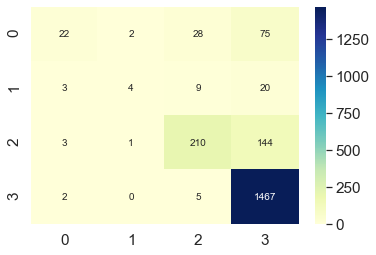

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [57]:
y_pred = model.predict(val)

print(metrics.classification_report(y_val, y_pred))
plot_confussion_matrix(y_val, y_pred)
plot_roc_curve(y_val, y_pred)

In [ ]:
# training an SVM on TF-IDF features
# Define the parameters to tune
"""
parameters = { 
    'C': [0.5, 5],
    'gamma': [1, 'auto', 'scale']
}
# Tune yyperparameters  using Grid Search and a SVM model
model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, n_jobs=-1).fit(train, y_train)
"""